# Visualizing Wolfgang Amadeus Mozart

## Import libraries and scrapy data from IMSLP

In [1]:
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup

url = "https://imslp.org/wiki/List_of_works_by_Wolfgang_Amadeus_Mozart"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [2]:
table = soup.find("table")
table_text = []

for row in table.findAll("tr"):
    cells = row.findAll(["th", "td"])
    # Remove new line from each string in the process
    cell_contents = [cell.text.replace("\n", "") for cell in cells]
    table_text.append(cell_contents)
raw_works = pd.DataFrame(table_text[1:], columns = table_text[0])
raw_works.head()

,K,K6,Title,Forces,Key,Date,Genre,Notes
0,—,001a,Andante,pf,C major,1761,Keyboard,
1,—,001b,Allegro,pf,C major,1761,Keyboard,No.2 in Nannerl's Music Book
2,—,001c,Allegro,pf,F major,1761,Keyboard,No.3 in Nannerl's Music Book
3,—,001d,Minuet,pf,F major,1761,Keyboard,No.4 in Nannerl's Music Book
4,001,001e,Minuet,pf,G major,1761–62,Keyboard,No.5 in Nannerl's Music Book


In [3]:
raw_works.tail()

,K,K6,Title,Forces,Key,Date,Genre,Notes
761,498a/3,Anh.C 25.05,Minuet,pf,B♭ major,?,Keyboard,published as part of spurious Piano Sonata in...
762,—,Anh.C 27.03,Fantasia,org,G minor,1787,Keyboard,incomplete
763,—,Anh.C 27.04,Romance,pf,A♭ major,?,Keyboard,incomplete; Mozart's authorship doubtful
764,—,Anh.C 27.10,Fugue,pf,E major,?,Keyboard,incomplete
765,046,—,Quintet,2vn 2va vc,B♭ major,—,Chamber,"spurious, anonymous arrangement of parts of K..."


In [4]:
raw_works.shape

(766, 8)

## Data cleaning

In [5]:
df = raw_works.copy()
df.columns = [column.lower() for column in df.columns]
df = df.apply(lambda x: x.str.strip() if x.dtype =='object' else x)

Only consider works with "k" numbers.

In [6]:
df = df[df['k'] != '—']
df.drop(df[(df['k'].str.contains('Anh.'))].index, inplace=True)
df.head()

,k,k6,title,forces,key,date,genre,notes
4,001,001e,Minuet,pf,G major,1761–62,Keyboard,No.5 in Nannerl's Music Book
6,002,002,Minuet,pf,F major,1762,Keyboard,No.7 in Nannerl's Music Book
7,003,003,Allegro,pf,B♭ major,1762,Keyboard,No.8 in Nannerl's Music Book
8,004,004,Minuet,pf,F major,1762,Keyboard,No.9 in Nannerl's Music Book
9,005,005,Minuet,pf,F major,1762,Keyboard,No.10 in Nannerl's Music Book


Key

In [7]:
if len(df[df["key"] == ""]) != 0:
    df = df[df["key"] != ""]

In [8]:
sorted(df["key"].unique())

['A major',
 'A minor',
 'A♭ major',
 'B minor',
 'B♭ major',
 'C major',
 'C minor',
 'D major',
 'D minor',
 'E major',
 'E minor',
 'E♭ major',
 'F major',
 'F minor',
 'G major',
 'G minor']

In [9]:
def decide_key(key):
    if "major" in key:
        if "minor" not in key:
            return "major"
        else:
            return "other"
    elif "minor" in key:
        if "major" not in key:
            return "minor"
        else:
            return "other"
    else:
        return None
df["mode"] = df["key"].apply(decide_key)

Date. That is usually a big trouble.

In [10]:
if len(df[df["date"] == ""]) !=0:
    df = df[df["date"] != ""]

In [11]:
df = df[df["date"].apply(lambda x: bool(re.search("[0-9]", x)))]
df["date"] = df["date"].str.replace("?","")
df["date"].min(), df["date"].max()

('1761–62', '1791')

In [12]:
df['min_date'] = df['date'].apply(lambda x: x.split('–')[0] if '–' in x else x)
df['max_date'] = df['date'].apply(lambda x: x.split('–')[1] if '–' in x else x)

In [13]:
df['min_date'] .unique()

array(['1761', '1762', '1763', '1764', '1765', '1766', '1772', '1767',
       '1768', '1769', '1770', '1771', '1777', '1773', '1774', '1775',
       '1776', '1780', '1779', '1772 or 1777', '1778', '1786', '1781',
       '1783', '1779, 1782', '1779, 1785', '1782', '1781, 1782', '1784',
       '1785', '1791', '1787', '1788', '1789', '1790'], dtype=object)

In [14]:
df['min_date'].replace('1772 or 1777','1772',inplace=True)
df['min_date'].replace('1779, 1782','1779',inplace=True)
df['min_date'].replace('1779, 1785','1779',inplace=True)
df['min_date'].replace('1781, 1782','1781',inplace=True)

In [15]:
df['max_date'].unique()

array(['62', '1762', '64', '63', '1763', '1764', '65', '66', '1765',
       '1766', '67', '1772', '1767', '1768', '1769', '73', '1770', '70',
       '74', '1771', '80', '72', '1774', '76', '1773', '1775', '1776',
       '1780', '1779', '77', '1777', '1772 or 1777', '1778', '1786', '82',
       '1783', '81', '83', '1779, 1785', '1781', '1782', '1781, 1782',
       '85', '1784', '86', '1791', '1787', '87', '84', '1785', '88',
       '1788', '1789', '1790', '91'], dtype=object)

In [16]:
df['max_date'].replace('1772 or 1777','1777',inplace=True)
df['max_date'].replace('1779, 1785','1785',inplace=True)
df['max_date'].replace('1781, 1782','1782',inplace=True)

In [17]:
df['min_date'] = df['min_date'].apply(int)
df['max_date'] = df['max_date'].apply(int)

In [18]:
df['max_date'] = df['max_date'].apply(lambda x : x + 1700 if x < 100 else x)
df['avg_date'] = (df['min_date'] + df['max_date'] )/2

In [19]:
df.reset_index(drop=True, inplace=True)
df.head()

,k,k6,title,forces,key,date,genre,notes,mode,min_date,max_date,avg_date
0,001,001e,Minuet,pf,G major,1761–62,Keyboard,No.5 in Nannerl's Music Book,major,1761,1762,1761.5
1,002,002,Minuet,pf,F major,1762,Keyboard,No.7 in Nannerl's Music Book,major,1762,1762,1762.0
2,003,003,Allegro,pf,B♭ major,1762,Keyboard,No.8 in Nannerl's Music Book,major,1762,1762,1762.0
3,004,004,Minuet,pf,F major,1762,Keyboard,No.9 in Nannerl's Music Book,major,1762,1762,1762.0
4,005,005,Minuet,pf,F major,1762,Keyboard,No.10 in Nannerl's Music Book,major,1762,1762,1762.0


## Visualze compositions

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Key

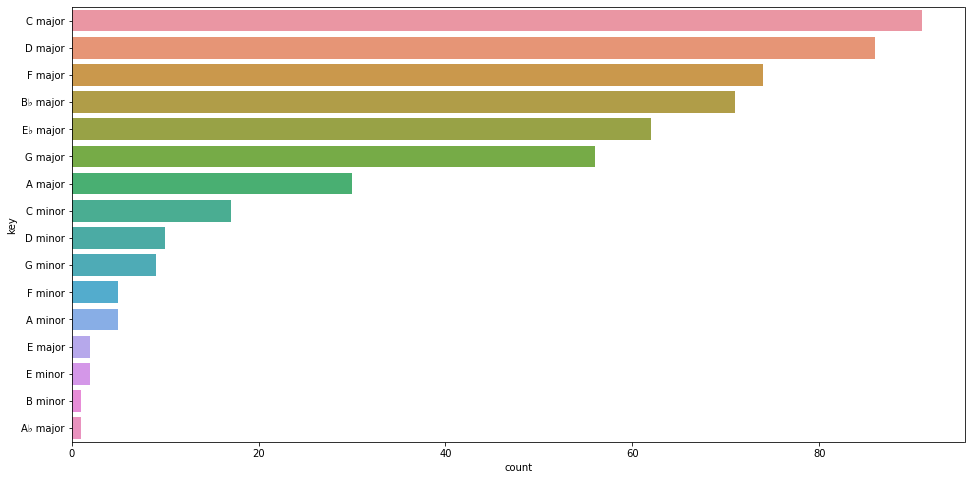

In [21]:
plt.figure(figsize=(16,8))
sns.countplot(y=df['key'], data=df, order = df['key'].value_counts().index)

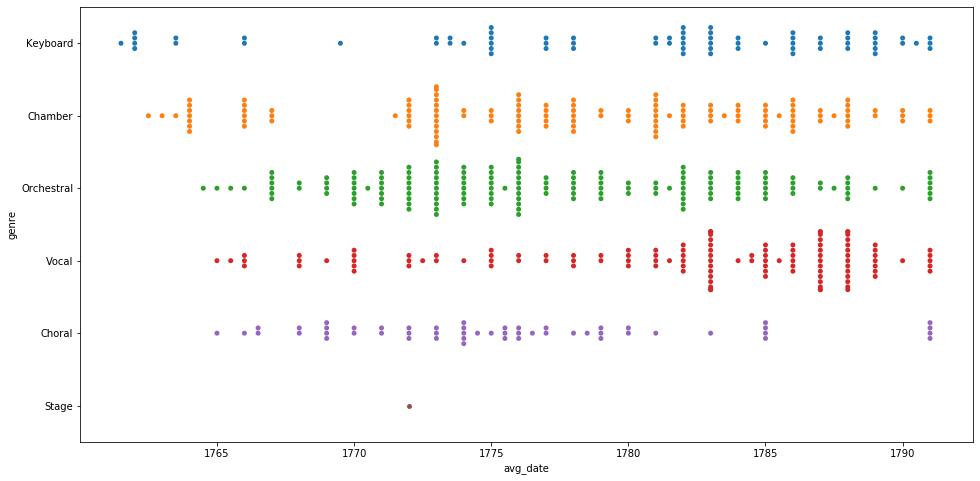

In [22]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['avg_date'],y=df['genre'])

Masterpiece. Piano Sonata

In [23]:
df.loc[df['title'].str.contains('Piano Sonata', case =False)]

,k,k6,title,forces,key,date,genre,notes,mode,min_date,max_date,avg_date
156,279,189d,Piano Sonata No.1,pf,C major,1775,Keyboard,,major,1775,1775,1775.0
157,280,189e,Piano Sonata No.2,pf,F major,1775,Keyboard,,major,1775,1775,1775.0
158,281,189f,Piano Sonata No.3,pf,B♭ major,1775,Keyboard,,major,1775,1775,1775.0
159,282,189g,Piano Sonata No.4,pf,E♭ major,1775,Keyboard,,major,1775,1775,1775.0
160,283,189h,Piano Sonata No.5,pf,G major,1775,Keyboard,,major,1775,1775,1775.0
165,284,205b,"Piano Sonata No.6 (""Durnitz"")",pf,D major,1775,Keyboard,,major,1775,1775,1775.0
225,309,284b,Piano Sonata No.7,pf,C major,1777,Keyboard,,major,1777,1777,1777.0
226,311,284c,Piano Sonata No.9,pf,D major,1777,Keyboard,,major,1777,1777,1777.0
247,310,300d,Piano Sonata No.8,pf,A minor,1778,Keyboard,,minor,1778,1778,1778.0
250,330,300h,Piano Sonata No.10,pf,C major,1783,Keyboard,,major,1783,1783,1783.0


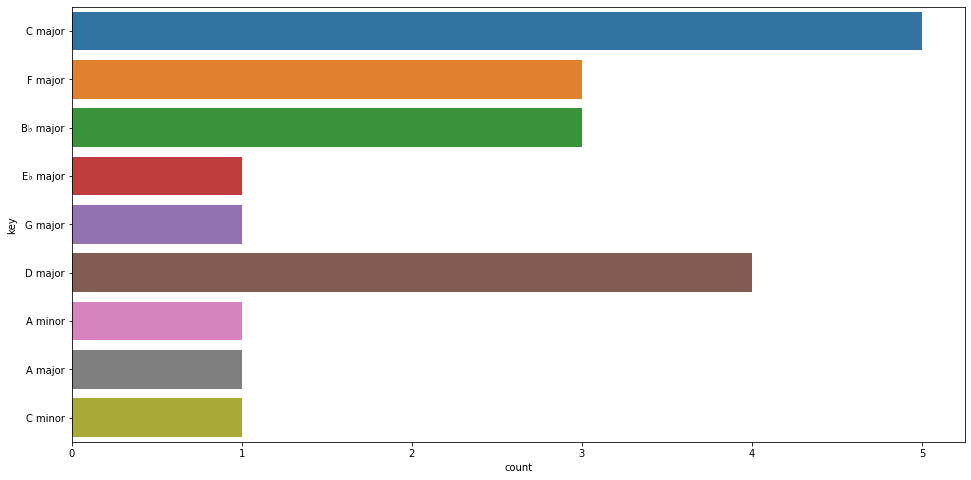

In [24]:
plt.figure(figsize=(16,8))
sns.countplot(y = df['key'][df['title'].str.contains('Piano Sonata')])

Masterpiece. Piano Concerto

In [25]:
# Piano concertos
df.loc[df['title'].str.contains('Piano Concerto', case =False)]

,k,k6,title,forces,key,date,genre,notes,mode,min_date,max_date,avg_date
37,037,037,Piano Concerto No.1,pf orch,F major,1767,Orchestral,,major,1767,1767,1767.0
38,039,039,Piano Concerto No.2,pf orch,B♭ major,1767,Orchestral,,major,1767,1767,1767.0
39,040,040,Piano Concerto No.3,pf orch,D major,1767,Orchestral,,major,1767,1767,1767.0
40,041,041,Piano Concerto No.4,pf orch,G major,1767,Orchestral,,major,1767,1767,1767.0
142,175,175,Piano Concerto No.5,pf orch,D major,1773,Orchestral,,major,1773,1773,1773.0
181,238,238,Piano Concerto No.6,pf orch,B♭ major,1776,Orchestral,,major,1776,1776,1776.0
189,242,242,"Piano Concerto No.7 (""Lodron"")",3pf orch,F major,1779,Orchestral,,major,1779,1779,1779.0
193,246,246,"Piano Concerto No.8 (""Lutzow"")",pf orch,C major,1776,Orchestral,,major,1776,1776,1776.0
213,271,271,"Piano Concerto No.9 (""Jeunehomme"" or ""Jenamy"")",pf orch,E♭ major,1777,Orchestral,,major,1777,1777,1777.0
256,365,316a,Piano Concerto No.10,2pf orch,E♭ major,1779–81,Orchestral,,major,1779,1781,1780.0


Masterpiece. Other non-piano concertos

In [26]:
# Non-piano concertos
df.loc[(df['title'].str.contains('Concerto', case =False)) & (~df['title'].str.contains('Piano Concerto', case =False))]

,k,k6,title,forces,key,date,genre,notes,mode,min_date,max_date,avg_date
147,190,186E,Concertone,2vn orch,C major,1774,Orchestral,,major,1774,1774,1774.0
148,191,186e,Bassoon Concerto,bn orch,B♭ major,1774,Orchestral,,major,1774,1774,1774.0
166,207,207,Violin Concerto No.1,vn orch,B♭ major,1773,Orchestral,,major,1773,1773,1773.0
170,211,211,Violin Concerto No.2,vn orch,D major,1775,Orchestral,,major,1775,1775,1775.0
177,216,216,"Violin Concerto No.3 (""Strassburg"")",vn orch,G major,1775,Orchestral,,major,1775,1775,1775.0
179,218,218,Violin Concerto No.4,vn orch,D major,1775,Orchestral,,major,1775,1775,1775.0
180,219,219,"Violin Concerto No.5 (""Turkish"")",vn orch,A major,1775,Orchestral,,major,1775,1775,1775.0
219,314,271k,Oboe Concerto,ob orch,C major,1775–77,Orchestral,revised as K.314/285d,major,1775,1777,1776.0
229,313,285c,"Flute Concerto (""No.1"")",fl orch,G major,1778,Orchestral,based on K.314/271k,major,1778,1778,1778.0
230,314,285d,"Flute Concerto (""No.2"")",fl orch,D major,1777,Orchestral,,major,1777,1777,1777.0


Masterpiece. Symphony

In [27]:
df.loc[df['title'].str.contains('Symphony No.', case =False)]

,k,k6,title,forces,key,date,genre,notes,mode,min_date,max_date,avg_date
17,016,016,Symphony No.1,orch,E♭ major,1764–65,Orchestral,,major,1764,1765,1764.5
18,019,019,Symphony No.4,orch,D major,1765–66,Orchestral,,major,1765,1766,1765.5
21,022,022,Symphony No.5,orch,B♭ major,1765,Orchestral,,major,1765,1765,1765.0
44,076,042a,Symphony No.43,orch,F major,1767,Orchestral,,major,1767,1767,1767.0
45,043,043,Symphony No.6,orch,F major,1767,Orchestral,,major,1767,1767,1767.0
46,045,045,Symphony No.7,orch,D major,1768,Orchestral,,major,1768,1768,1768.0
52,048,048,Symphony No.8,orch,D major,1768,Orchestral,,major,1768,1768,1768.0
71,081,073l,Symphony No.44,orch,D major,1770,Orchestral,,major,1770,1770,1770.0
72,097,073m,Symphony No.47,orch,D major,1770,Orchestral,,major,1770,1770,1770.0
73,095,073n,Symphony No.45,orch,D major,1770,Orchestral,,major,1770,1770,1770.0


Sadly, Mozart left many incmplete works. 

In [28]:
df.loc[df['notes'].str.contains('incomplete', case =False)]

,k,k6,title,forces,key,date,genre,notes,mode,min_date,max_date,avg_date
6,009b,005b,Andante,pf,B♭ major,1763–64,Keyboard,No.12 in Nannerl's Music Book; incomplete,major,1763,1764,1763.5
61,071,071,"Ah, più tremar non voglio",v orch,F major,1769,Vocal,incomplete,major,1769,1769,1769.0
152,091,186i,Kyrie,ch orch,D major,1774,Choral,incomplete,major,1774,1774,1774.0
239,322,296a,Kyrie,ch orch,E♭ major,1778,Choral,incomplete,major,1778,1778,1778.0
285,371,371,Rondo,hn orch,E♭ major,1781,Orchestral,incomplete,major,1781,1781,1781.0
286,372,372,Allegro,vn pf,B♭ major,1781,Chamber,incomplete,major,1781,1781,1781.0
287,400,372a,Allegro,pf,B♭ major,1782,Keyboard,incomplete,major,1782,1782,1782.0
299,401,375e,Fugue,pf4h,G minor,1773,Keyboard,incomplete,minor,1773,1773,1773.0
300,153,375f,Fugue,pf,E♭ major,1782,Keyboard,incomplete,major,1782,1782,1782.0
314,440,383h,"In te spero, o sposo amato",v orch,C major,1782,Vocal,incomplete,major,1782,1782,1782.0
